## Embedding Projection for Higher Modality(T-SNE, PCA, Umap)
+ In this notebook we use different projection for the last layer prior to the softmax layer in the CNN-

## 1. Importing Libraries

In [2]:
import os
import sys
module_path = "../src"
#os.environ["WANDB_SILENT"] = "true" # Environment Variable to make wandb silent
if module_path not in sys.path:
    sys.path.append(module_path)
# 1. General Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# 2. DataModule & Class Libraries
from utils.label_encoder import label_encoder_target
from utils.calc_stat import calc_dataset_mean_std
from utils.FeatureExtractor import get_vector_representation,prepare_projection
from dataset.ImageDataModule import ImageDataModule
from dataset.ImageDataset import ImageDataset
from models.EfficientNetClass import EfficientNetClass
from models.ResNetClass import ResNetClass
# 3. Pytorch & Pytorch Lightning Libraries
from pytorch_lightning import Trainer,seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import torch
# 4. Wandb Tracker Experiements
import wandb

In [2]:
DATA_PATH = '../data/higher_modality_vol1.csv'
BASE_PATH = Path('/mnt')
BASE_IMG_DIR = BASE_PATH / 'subfigure-classification'
SEED = 42
model_path = '/mnt/artifacts/models/Higher_Modality/higher_modality_v1.pt'
#model_path = '/mnt/artifacts/experiments/Biomedical-Image-Classification-Higher-Modality/pn8e9eb0/wild-sweep-1/last.pt'

## 2. Feature Extraction - ResNet CNN

## 2.1 Higher - Modality

In [3]:
df = pd.read_csv(DATA_PATH, sep='\t')
le_encoder,dict_label = label_encoder_target(df,target_col='higher_modality')
df.head()

,img,modality,set,source,img_path,higher_modality,caption,split_set
0,11373_2007_9226_Fig1_HTML-10.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-10.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN
1,11373_2007_9226_Fig1_HTML-11.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-11.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN
2,11373_2007_9226_Fig1_HTML-12.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-12.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN
3,11373_2007_9226_Fig1_HTML-13.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-13.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN
4,11373_2007_9226_Fig1_HTML-14.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-14.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN


In [4]:
# 3.1 Load the Resnet Model
model = ResNetClass.load_from_checkpoint(model_path)
print('*'*5,' Resnet Model Parameters ','*'*5)
print(model.hparams)
print('*'*5,' Resnet Model Children ','*'*5)
children_counter = 0
for n,c in model.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1

*****  Resnet Model Parameters  *****
"class_weights":   [4.38888889 0.52605967 0.72953294 3.14067278 0.56028369 2.51715686]
"fine_tuned_from": whole
"lr":              1e-05
"mean_dataset":    tensor([0.6420, 0.6370, 0.6353])
"metric_monitor":  val_avg_loss
"mode_scheduler":  min
"name":            resnet101
"num_classes":     6
"pretrained":      True
"std_dataset":     tensor([0.3706, 0.3698, 0.3734])
*****  Resnet Model Children  *****
Children Counter:  0  Layer Name:  model


## 3. Embedding Projection - ResNet CNN

In [23]:
prepare_projection(model,le_encoder,DATA_PATH,BASE_IMG_DIR,SEED,VERSION = 1)

Feature Vector for training: 



Feature Vector for Validation: 



Feature Vector for Test: 



***** PCA *****
***** UMAP *****


### 3.1 UMAP

In [12]:
%%time
df_projection = pd.read_parquet( '/mnt/artifacts/projections/higher_modality_v1.parquet')

CPU times: user 221 ms, sys: 296 ms, total: 517 ms
Wall time: 495 ms


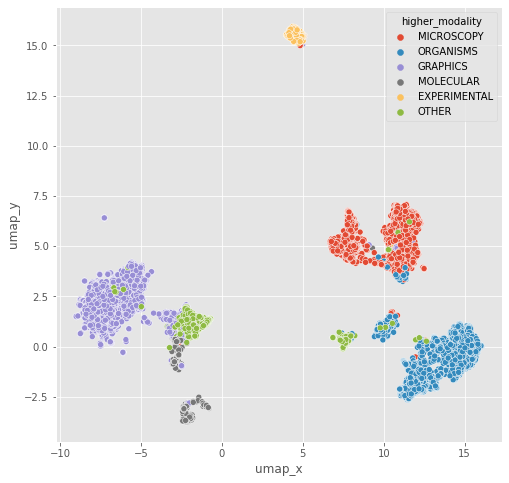

In [26]:
plt.figure(figsize=(8,8))
df1 = df_projection[df_projection['split_set']=='TRAIN'].reset_index(drop = True)
sns.scatterplot(data=df1, x="umap_x", y="umap_y", hue="higher_modality")
plt.show()

### 3.2 PCA

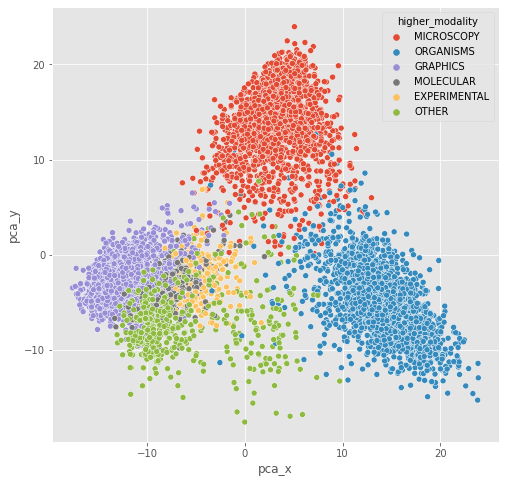

In [27]:
plt.figure(figsize=(8,8))
df1 = df_projection[df_projection['split_set']=='TRAIN'].reset_index(drop = True)
sns.scatterplot(data=df1, x="pca_x", y="pca_y", hue="higher_modality")
plt.show()